# **AOML COURSE PROJECT**

HIYA JAIN - PES1UG22AM069

NEERAJ - PES1UG22AM102

R DEEKSHA - PES1UG22AM125

ASTHA KUMARI - PES1UG22AM910




---



# Generating the micro doppler dataset


In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import chirp, spectrogram

# Parameters
sampling_rate = 2000  # Hz (Increased for higher frequency resolution)
duration = 2.0  # Duration of each signal in seconds
time = np.linspace(0, duration, int(sampling_rate * duration), endpoint=False)  # Time vector for the signals
output_folder = "micro_doppler_dataset"  # Folder to save the dataset
os.makedirs(output_folder, exist_ok=True)

# Creating subfolders for each class of signals
classes = ["birds", "drones", "clutter"]
for cls in classes:
    os.makedirs(os.path.join(output_folder, cls), exist_ok=True)

# Function to generate bird Doppler signature
def generate_bird_doppler(num_samples, time):
    data = []  # List to hold generated bird Doppler signals
    for _ in range(num_samples):
        wingbeat_frequency = np.random.uniform(20, 40)  # Random wingbeat frequency for variability
        doppler_shift = chirp(
            time, f0=wingbeat_frequency, f1=wingbeat_frequency + np.random.uniform(5, 15),
            t1=duration, method="quadratic"  # Generating a chirp signal representing Doppler shift
        )
        harmonic = chirp(
            time, f0=wingbeat_frequency * 2, f1=wingbeat_frequency * 2.5,
            t1=duration, method="quadratic"  # Generating a harmonic chirp signal
        )
        noise = np.random.normal(0, 0.1, doppler_shift.shape)  # Adding Gaussian noise to the signal
        data.append(doppler_shift + harmonic + noise)  # Combining the signals and noise
    return data

# Function to generate drone Doppler signature with flight patterns
def generate_drone_doppler(num_samples, time):
    data = []  # List to hold generated drone Doppler signals
    for _ in range(num_samples):
        flight_pattern = np.random.choice(["hovering", "cruising", "ascent", "descent", "sharp_turn"])  # Random flight patterns

        if flight_pattern == "hovering":
            frequency = np.random.uniform(80, 100)
            signal = np.sin(2 * np.pi * frequency * time)  # Sine wave for hovering drones
        elif flight_pattern == "cruising":
            frequency = np.random.uniform(100, 150)
            signal = chirp(time, f0=frequency, f1=frequency + 50, t1=duration, method="linear")  # Linear chirp for cruising
        elif flight_pattern == "ascent":
            signal = chirp(time, f0=60, f1=150, t1=duration, method="linear")  # Ascent pattern
        elif flight_pattern == "descent":
            signal = chirp(time, f0=150, f1=60, t1=duration, method="linear")  # Descent pattern
        elif flight_pattern == "sharp_turn":
            base_frequency = np.random.uniform(100, 130)
            signal = (
                np.sin(2 * np.pi * base_frequency * time) *
                np.sin(2 * np.pi * np.random.uniform(1, 5) * time)  # Complex pattern for sharp turns
            )

        noise = np.random.normal(0, 0.15, signal.shape)  # Adding Gaussian noise to the signal
        data.append(signal + noise)  # Combining the signals and noise
    return data

# Function to generate clutter Doppler signature
def generate_clutter(num_samples, time):
    data = []  # List to hold generated clutter signals
    for _ in range(num_samples):
        noise = np.random.normal(0, np.random.uniform(0.5, 1.0), len(time))  # Random noise for clutter
        wind_noise = np.sin(2 * np.pi * np.random.uniform(1, 3) * time) * np.random.uniform(0.1, 0.5)  # Wind noise component
        rain_noise = np.random.uniform(-0.2, 0.2, len(time))  # Rain noise component
        data.append(noise + wind_noise + rain_noise)  # Combining all components into clutter signal
    return data

# Generating synthetic data for each class of signals
num_samples_per_class = 200  # Number of samples per class
bird_data = generate_bird_doppler(num_samples_per_class, time)   # Generating bird Doppler signatures
drone_data = generate_drone_doppler(num_samples_per_class, time)   # Generating drone Doppler signatures
clutter_data = generate_clutter(num_samples_per_class, time)       # Generating clutter signatures

# Combining data and labels into a dictionary for easy access later
data = {"birds": bird_data, "drones": drone_data, "clutter": clutter_data}
csv_data = []  # List to hold metadata for CSV file

# Saving spectrograms and metadata for each generated signal
for label, signals in data.items():
    class_folder = os.path.join(output_folder, label)   # Path to the current class folder
    for i, signal in enumerate(signals):
        # Generating spectrogram with enhanced resolution using scipy's spectrogram function
        f, t, Sxx = spectrogram(signal, fs=sampling_rate, nperseg=256, noverlap=128)

        # Saving spectrogram image as PNG file
        img_file = os.path.join(class_folder, f"{label}_{i}.png")
        plt.figure(figsize=(5, 4))
        plt.pcolormesh(t, f, 10 * np.log10(Sxx), shading="gouraud")   # Plotting the spectrogram with logarithmic scale for power
        plt.title(f"{label.capitalize()} Spectrogram")   # Title of the plot based on the label (birds/drones/clutter)
        plt.ylabel("Frequency [Hz]")   # Y-axis label for frequency
        plt.xlabel("Time [s]")         # X-axis label for time
        plt.colorbar(label="Power [dB]")   # Colorbar indicating power level in dB
        plt.savefig(img_file)
        plt.close()

        # Appending metadata about the saved image file and its label to csv_data list
        csv_data.append({"file_path": img_file, "label": label})

# Saving metadata about all generated images into a CSV file
csv_file = os.path.join(output_folder, "metadata.csv")
pd.DataFrame(csv_data).to_csv(csv_file, index=False)   # Creating a DataFrame from csv_data and save it as CSV

print(f"Dataset saved in folder '{output_folder}', with metadata in 'metadata.csv'.")

Dataset saved in folder 'micro_doppler_dataset', with metadata in 'metadata.csv'.


# Data preparation


In [2]:
import os
import numpy as np
import pandas as pd
import cv2
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

# Loading metadata from CSV file
metadata_path = "/content/micro_doppler_dataset/metadata.csv"
metadata = pd.read_csv(metadata_path)

# Parameters for image processing
image_size = (128, 128)  # Resizing spectrograms to this target size for model input

# Function to load images and their corresponding labels from metadata
def load_images_and_labels(metadata, image_size):
    images = []
    labels = []  # List to hold the corresponding labels of the images
    for _, row in metadata.iterrows():
        img_path = os.path.join("/content", row["file_path"])  # Constructing full image path
        img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)  # Reading image as grayscale (single channel)
        img_resized = cv2.resize(img, image_size)  # Resizing image to target size (128x128)
        images.append(img_resized)  # Appending resized image to the list
        labels.append(row["label"])  # Collecting label from the row
    return np.array(images), np.array(labels)

images, labels = load_images_and_labels(metadata, image_size)

# Normalizing images to scale pixel values (originally [0, 255]) to [0, 1]
images = images / 255.0

# Encoding labels into numerical format for model training
label_mapping = {label: idx for idx, label in enumerate(metadata["label"].unique())}

# Creating a mapping from label names to integers (e.g., 'birds': 0, 'drones': 1, 'clutter': 2)
reverse_mapping = {v: k for k, v in label_mapping.items()}  # reverse mapping for prediction interpretation

# Converting string labels to their corresponding integer values using the mapping
labels = np.array([label_mapping[label] for label in labels])

# Converting integer labels to one-hot encoded format for multi-class classification
labels = to_categorical(labels, num_classes=len(label_mapping))

# Splitting data into training and testing datasets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.2, random_state=42)

# Adding channel dimension for CNN input (from shape (128, 128) to (128, 128, 1))
X_train = X_train[..., np.newaxis]
X_test = X_test[..., np.newaxis]

print("Data preparation complete.")

Data preparation complete.


# Creating CNN model

In [3]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Creating a CNN model for image classification
def create_model(input_shape, num_classes):
    model = Sequential([         # Initializing a sequential model
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),  # First convolutional layer
        # 32 filters of size 3x3 with ReLU activation function
        MaxPooling2D((2, 2)),  # First max pooling layer to downsample the feature maps
        Dropout(0.2),  # Dropout layer to reduce overfitting by randomly setting 20% of the input units to 0

        Conv2D(64, (3, 3), activation='relu'),  # Second convolutional layer with 64 filters
        MaxPooling2D((2, 2)),  # Second max pooling layer
        Dropout(0.3),  # Dropout layer with a higher dropout rate of 30%

        Conv2D(128, (3, 3), activation='relu'),  # Third convolutional layer with 128 filters
        MaxPooling2D((2, 2)),  # Third max pooling layer
        Flatten(),  # Flattening the output from the previous layer to feed into the dense layers

        Dense(128, activation='relu'),  # Fully connected dense layer with 128 units and ReLU activation
        Dropout(0.4),  # Dropout layer with a dropout rate of 40%
        Dense(num_classes, activation='softmax')  # Output layer with softmax activation for multi-class classification
    ])
    return model

# Defining the input shape and number of classes based on the previous data preparation step
input_shape = (image_size[0], image_size[1], 1)  # Input shape for grayscale images (128x128 pixels)
num_classes = len(label_mapping)  # Number of output classes based on label mapping

# Creating the CNN model using the defined function
model = create_model(input_shape, num_classes)

# Compiling the model with Adam optimizer and categorical crossentropy loss function
model.compile(optimizer=Adam(learning_rate=0.001), loss="categorical_crossentropy", metrics=["accuracy"])

# Displaying a summary of the model architecture
model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 3)                   │             387 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,304,451 (12.61 MB)

 Trainable params: 3,304,451 (12.61 MB)

 Non-trainable params: 0 (0.00 B)

# Training and evaluating the model

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

# Early stopping to prevent overfitting
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitoring the validation loss during training
    patience=5,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True  # Restoring model weights from the epoch with the best validation loss
)

# Training the model on the training data
history = model.fit(
    X_train, y_train,
    validation_split=0.2,       # Using 20% of the training data for validation
    epochs=30,                   # Number of epochs to train the model
    batch_size=32,               # Number of samples per gradient update
    callbacks=[early_stopping]   # Including early stopping callback to monitor training
)

# Saving the trained model to a file for future use
model.save("micro_doppler_model.h5")
print("Model training complete and saved.")

Epoch 1/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 8s 107ms/step - accuracy: 0.3213 - loss: 1.2908 - val_accuracy: 0.3229 - val_loss: 1.0980
Epoch 2/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 4s 25ms/step - accuracy: 0.4462 - loss: 1.0513 - val_accuracy: 0.6667 - val_loss: 0.9174
Epoch 3/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - accuracy: 0.5938 - loss: 0.8359 - val_accuracy: 0.6562 - val_loss: 0.7170
Epoch 4/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.6563 - loss: 0.5830 - val_accuracy: 0.6562 - val_loss: 0.5467
Epoch 5/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.7235 - loss: 0.4613 - val_accuracy: 0.8750 - val_loss: 0.4251
Epoch 6/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8679 - loss: 0.3607 - val_accuracy: 0.9583 - val_loss: 0.3050
Epoch 7/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8603 - loss: 0.3268 - val_accuracy: 0.7188 - val_loss: 0.4095
Epoch 8/30
12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step - accuracy: 0.8345 - loss: 0.3282 - val_accuracy: 0.9688 - 

Model training complete and saved.


In [ ]:
# Evaluating the trained model on the test dataset
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Loss: 0.0276
Test Accuracy: 0.9917


# Testing out the model on an individual spectogram image


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 561ms/step


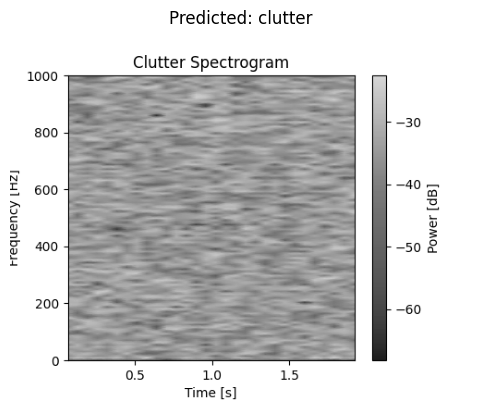

In [ ]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import matplotlib.pyplot as plt

model = load_model("micro_doppler_model.h5")  # Loading the saved model

# Defining label mapping using the reverse mapping created earlier
reverse_mapping = {v: k for k, v in label_mapping.items()}  # Mapping numeric predictions back to original labels

# Function to preprocess an image and predict its class using the trained model
def predict_image(image_path):
    img = load_img(image_path, color_mode='grayscale', target_size=(128, 128))  # Loading the image for prediction (resize to 128x128 pixels)
    img_array = img_to_array(img)  # Converting the image to a NumPy array
    img_array_for_display = np.copy(img_array)
    img_array = img_array / 255.0  # Normalizing pixel values to range [0, 1]
    img_array = np.expand_dims(img_array, axis=0)  # Adding batch dimension (shape becomes (1, 128, 128, 1))

    # Predicting the class of the preprocessed image using the trained model
    predictions = model.predict(img_array)  # Getting predictions from the model
    predicted_class = np.argmax(predictions, axis=1)[0]  # Getting the index of the highest predicted probability
    predicted_label = reverse_mapping[predicted_class]  # Mapping index back to original label

    # Loading the original image for display (without resizing)
    original_img = load_img(image_path, color_mode='grayscale')

    # Displaying the original image with its predicted label
    plt.imshow(original_img, cmap="gray")
    plt.title(f"Predicted: {predicted_label}")
    plt.axis('off')
    plt.show()

# Predicting on a specific image
predict_image("/content/micro_doppler_dataset/clutter/clutter_10.png")


# Confusion matrix

4/4 ━━━━━━━━━━━━━━━━━━━━ 2s 402ms/step


<Figure size 800x800 with 0 Axes>

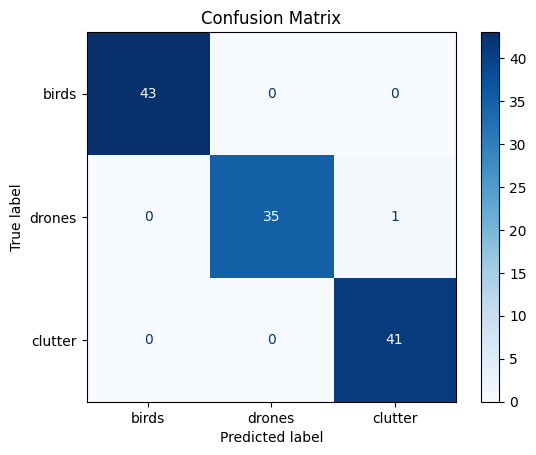

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Function to decode one-hot encoded labels back to integer class labels
def decode_labels(one_hot_labels):
    return np.argmax(one_hot_labels, axis=1)

# Decoding true labels from the one-hot encoded format
true_labels = decode_labels(y_test)  # Converting true labels back to integer format

# Generating predictions from the model for the test dataset
predicted_probabilities = model.predict(X_test)  # Getting predicted probabilities for each class
predicted_labels = decode_labels(predicted_probabilities)  # Converting predicted probabilities to class labels

# Computing the confusion matrix from true and predicted labels to evaluate model performance
cm = confusion_matrix(true_labels, predicted_labels)

# Creating a display for the confusion matrix with appropriate labels
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=list(label_mapping.keys()))

# Plotting the confusion matrix using Matplotlib
plt.figure(figsize=(8, 8))
disp.plot(cmap=plt.cm.Blues, values_format='d')
plt.title("Confusion Matrix")
plt.show()